# **Assignment-2 for CS60075: Natural Language Processing**

#### Instructor : Prof. Sudeshna Sarkar

#### Teaching Assistants : Alapan Kuila, Aniruddha Roy, Prithwish Jana, Udit Dharmin Desai

#### Date of Announcement: 15th Sept, 2021
#### Deadline for Submission: 11.59pm on Wednesday, 22nd Sept, 2021 
#### Submit this .ipynb file, named as `<Your_Roll_Number>_Assn2_NLP_A21.ipynb`

The central idea of this assignment is to use Naive Bayes classifier and LSTM based classifier and compare the models by accuracy on IMDB dataset.  This dataset consists of 50k movie reviews (25k positive, 25k negative). You can download the dataset from https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews



Please submit with outputs. 

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import classification_report

In [2]:
#Load the IMDB dataset. You can load it using pandas as dataframe
df = pd.read_csv("IMDB Dataset.csv")
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Preprocessing
PrePrecessing that needs to be done on lower cased corpus

1. Remove html tags
2. Remove URLS
3. Remove non alphanumeric character
4. Remove Stopwords
5. Perform stemming and lemmatization

You can use regex from re. 

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bolkbam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bolkbam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bolkbam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def preprocess(corpus):
    corpus = corpus.lower()
    corpus = re.compile(r'<[^>]+>').sub("",corpus)   #removing html tags
    corpus = re.sub(r"http\S+", "", corpus)
    corpus = re.sub(r'https?:\/\/.*[\r\n]*', '', corpus) #removing URLS 
    corpus = re.sub(r"[^a-zA-Z0-9]+", " ", corpus) #removing non alphanumeric character
    tokenized = word_tokenize(corpus)
    filtered_list = [word for word in tokenized if not word in stop_words] #stopwords removal
    lemmatizer = WordNetLemmatizer()
    lem_words = [lemmatizer.lemmatize(word,pos="n") for word in filtered_list] #lemmatization
    s = ' '.join(lem_words)
    return s 

df["review"] = df["review"].apply(preprocess) 
df.head(10)

,review,sentiment
0,one reviewer mentioned watching 1 oz episode h...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive
5,probably time favorite movie story selflessnes...,positive
6,sure would like see resurrection dated seahunt...,positive
7,show amazing fresh innovative idea 70 first ai...,negative
8,encouraged positive comment film looking forwa...,negative
9,like original gut wrenching laughter like movi...,positive


Avg length of sentences:  119.56162


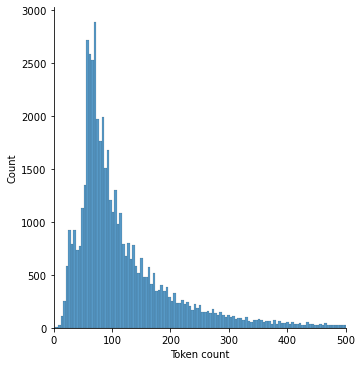

In [6]:
# Print Statistics of Data like avg length of sentence , proposition of data w.r.t class labels
import seaborn as sns
import matplotlib.pyplot as plt

sent_len = []

for sent in df.review[0:]:
    sent_tokenized = word_tokenize(sent)  #tokenizing each sentences 
    length = len(sent_tokenized)
    sent_len.append(length)
   

avg = sum(sent_len)/len(sent_len)
print("Avg length of sentences: ", avg)


#From the plot we can observe that most of the sentences length is around 100
sns.displot(sent_len)
plt.xlim([0, 500]);
plt.xlabel('Token count');

<BarContainer object of 2 artists>

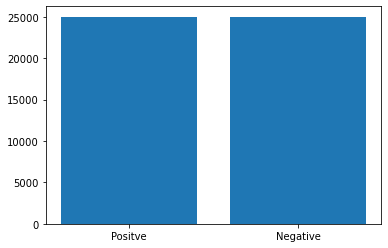

In [7]:
## Counting the number of positive and negative reviews
## Result -> Pos = Neg = 25K , Observe the bar graph below
pos=0
neg=0
for w in df.sentiment[0:]:
    if w == 'positive':
        pos = pos + 1
    else:
        neg = neg + 1
plt.bar(['Positve','Negative'],[pos,neg])

# Naive Bayes classifier

In [8]:
# get reviews column from df
reviews = df["review"]

# get labels column from df
labels = df["sentiment"]

In [9]:
# Use label encoder to encode labels. Convert to 0/1
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# print(enc.classes_)
print(encoder.classes_)
print(encoded_labels)

['negative' 'positive']
[1 1 1 ... 0 0 0]


In [10]:
# Split the data into train and test (80% - 20%). 
# Use stratify in train_test_split so that both train and test have similar ratio of positive and negative samples.

train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews,encoded_labels, test_size=0.2, random_state=0 ,stratify = encoded_labels)
print(len(train_sentences))
print(len(test_sentences))
# train_sentences, test_sentences, train_labels, test_labels

40000
10000


Here there are two approaches possible for building vocabulary for the naive Bayes.
1. Take the whole data (train + test) to build the vocab. In this way while testing there is no word which will be out of vocabulary.
2. Take the train data to build vocab. In this case, some words from the test set may not be in vocab and hence one needs to perform smoothing so that one the probability term is not zero.
 
You are supposed to go by the 2nd approach.
 
Also building vocab by taking all words in the train set is memory intensive, hence you are required to build vocab by choosing the top 2000 - 3000 frequent words in the training corpus.

> $ P(x_i | w_j) = \frac{ N_{x_i,w_j}\, +\, \alpha }{ N_{w_j}\, +\, \alpha*d} $


$N_{x_i,w_j}$ : Number of times feature $x_i$ appears in samples of class $w_j$

$N_{w_j}$ : Total count of features in class $w_j$

$\alpha$ : Parameter for additive smoothing. Here consider $\alpha$ = 1

$d$ : Dimentionality of the feature vector  $x = [x_1,x_2,...,x_d]$. In our case its the vocab size.






In [11]:
from sklearn.feature_extraction.text import CountVectorizer
# Use Count vectorizer to get frequency of the words
'''
max_features parameter : If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
vec = CountVectorizer(max_features = 3000)
X = vec.fit_transform(Sentence_list)
'''
vec = CountVectorizer(max_features = 3000)
X = vec.fit_transform(train_sentences)
V = X.toarray()
Vocab = vec.vocabulary_   #vocabulary of top 3000 frequent words
V.shape

(40000, 3000)

In [12]:
#function for counting occurrences of top 3000 words in the training sentences/reviews 
def word_count(reviews,lbl,vocab):
    freqs = {}
    for rev,lb in zip(reviews,lbl):
        word_list = word_tokenize(rev) #tokenizing reviews
        for word in word_list:
            if word in vocab.keys():  # if current word is in vocabulary 
                pair = (word,lb)      # creating key -> tuple of word and label
                if pair in freqs:     # if key already present, increase the count
                    freqs[pair] += 1  # else add it to the dictionary with count 1 
                else:
                    freqs[pair] = 1
    return freqs

In [13]:
freqs = word_count(train_sentences,train_labels,Vocab) 

Np = 0   # count of features in positive reviewed sentences
Nn = 0   # count of features in negative reviewed sentences
for word in Vocab.keys() :
    Np += freqs.get((word,1))
    Nn += freqs.get((word,0))
print(Np)
print(Nn)

1849849
1832542


In [14]:
# Use laplace smoothing for words in test set not present in vocab of train set
# Implemented below in the model itself

In [15]:
# Build the model. Don't use the model from sklearn

def naive_bayes(words,feature_size,N_pos,N_neg,freqs,Vocab):
    ppos = 0
    pneg = 0
    for word in words:
        if word in Vocab.keys():
            ppos += np.log((freqs.get((word,1))+1)/(N_pos + feature_size)) # ppos = (ppos) * (freqs.get((word,1),0)+1/(N_pos+feature_size))
            pneg += np.log((freqs.get((word,0))+1)/(N_neg + feature_size)) # pneg = (pneg) * (freqs.get((word,0),0)+1/(N_neg+feature_size))
          
        else :
            ppos +=  np.log(1/(N_pos+feature_size)) 
            pneg += np.log(1/(N_neg+feature_size))  
          
    ppos += np.log(N_pos/(N_pos+N_neg))                                   # ppos *= (N_pos/(N_pos+N_neg))
    pneg += np.log(N_neg/(N_pos+N_neg))                                   # pneg *= (N_neg/(N_pos+N_neg)) 

    
    if ppos>pneg:
        return 1
    else :
        return 0

In [16]:
# Test the model on test set and report Accuracy

N = 3000                        # total count of features = Vocab size 
yh = []
for sent in test_sentences:
    words = word_tokenize(sent)
    yh_i = naive_bayes(words,N,Np,Nn,freqs,Vocab)
    yh.append(yh_i)

In [17]:
y_test = test_labels.tolist()
y_h = np.array(yh)
error = np.mean(np.absolute(y_h-test_labels))
accuracy = 1-error
accuracy

0.8439

# *LSTM* based Classifier

Use the above train and test splits.

In [18]:
# Hyperparameters of the model
vocab_size = 3000 # choose based on statistics
oov_tok = '<OOK>'
embedding_dim = 100
max_length = 200 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'

In [19]:
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [20]:
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          300000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 387,601
Trainable params: 387,601
Non-trainable params: 0
_________________________________________________________________


In [21]:
num_epochs = 5
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5
1125/1125 [==============================] - 217s 189ms/step - loss: 0.3987 - accuracy: 0.8218 - val_loss: 0.3514 - val_accuracy: 0.8615
Epoch 2/5
1125/1125 [==============================] - 200s 178ms/step - loss: 0.2936 - accuracy: 0.8809 - val_loss: 0.3242 - val_accuracy: 0.8725
Epoch 3/5
1125/1125 [==============================] - 198s 176ms/step - loss: 0.2459 - accuracy: 0.9036 - val_loss: 0.3054 - val_accuracy: 0.8777
Epoch 4/5
1125/1125 [==============================] - 196s 174ms/step - loss: 0.2182 - accuracy: 0.9149 - val_loss: 0.3137 - val_accuracy: 0.8723
Epoch 5/5
1125/1125 [==============================] - 201s 178ms/step - loss: 0.1883 - accuracy: 0.9281 - val_loss: 0.3246 - val_accuracy: 0.8852


In [22]:
# Calculate accuracy on Test data
'''
prediction = model.predict(test_padded)

'''
# Get probabilities
prediction = model.predict(test_padded)

# Get labels based on probability 1 if p>= 0.5 else 0
prediction = (prediction>=0.5)

# Accuracy : one can use classification_report from sklearn
from sklearn.metrics import classification_report
print(classification_report(test_labels, prediction))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5000
           1       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Get predictions for random examples

In [23]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this", 
            "the movie plot is terrible but it had good acting"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=max_length)

# Get probabilities
pred = model.predict(padded)
#print(model.predict(padded))

# Get labels based on probability 1 if p>= 0.5 else 0
pred = pred>=0.5 
pred = pred +1 -1
print(pred)

[[1]
 [0]
 [0]]
